In [2]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Supress Warnings
import warnings 
warnings.filterwarnings('ignore')
#The last line of code helps in suppressing the unnecessary warnings.
from scipy import stats
import seaborn as sns

In [3]:
# Set global font settings
plt.rc('axes', titlesize=16, titleweight='bold', labelsize=14, labelweight='bold')  # For axes title and labels
plt.rc('xtick', labelsize=12)  # For x-axis tick labels
plt.rc('ytick', labelsize=12)  # For y-axis tick labels


In [4]:
# Data Collection:
# Using the Specify Absolute Path: If the file is located in a different directory, you can specify the absolute path to the file when reading it using pd.read_csv():
import pandas as pd
file_path = r'C:\Users\User\Desktop\Thesis 2023\Capstone---CCT\Python Working Notebooks\ProductionDataupdated1.csv'
ProductionTank = pd.read_csv(file_path)

In [5]:
ProductionTank.head()

,Unnamed: 0,Material,BATCHID,Tank_1,Instruction_Step,INGRED_ID,INGRED_Name,Quantity,Phase_start,Phase_end,Phase_duration,Phase_start_delay,Phase_row_no,Flowrate_KGMIN,Target_Flowrate,Target_Phase_duration,Phase_overrun,Deaeration Phase
0,0,1002150,107643491,2503,S3_BATCH_IN_PROGRESS,NaN,NaN,0.000,09/03/2022 10:42,09/03/2022 10:42,0,0,1,0.0000,NaN,0,NaN,0
1,1,1002150,107643491,2503,STEP1_CONS,1002565,WATER TREATED,5760.000,09/03/2022 10:42,09/03/2022 11:16,34,0,2,169.4118,733.5050,8,26.0,0
2,2,1002150,107643491,2503,PLEASE VERIFY BULK ADDITION,NaN,NaN,0.000,09/03/2022 11:16,09/03/2022 11:17,1,0,3,0.0000,NaN,3,0.0,0
3,3,1002150,107643491,2503,STEP1_CONS,1037802,S813 SOD BENZOATE XFX25,5.629,09/03/2022 11:17,09/03/2022 11:27,10,0,4,0.5629,6.3182,1,9.0,0
4,4,1002150,107643491,2503,STEP1_CONS,1002818,S651 CITRIC ACID ANH BG XFX25,78.766,09/03/2022 11:27,09/03/2022 11:38,11,0,5,7.1605,6.3182,12,0.0,0


In [6]:
ProductionTank.drop(columns=['Unnamed: 0'], inplace=True)

## Examining the Phase Overrun duration times for the GUM ingredient addition - Addition of GUM ingredients to the specific production tanks based on their capacity
 This is completed manually

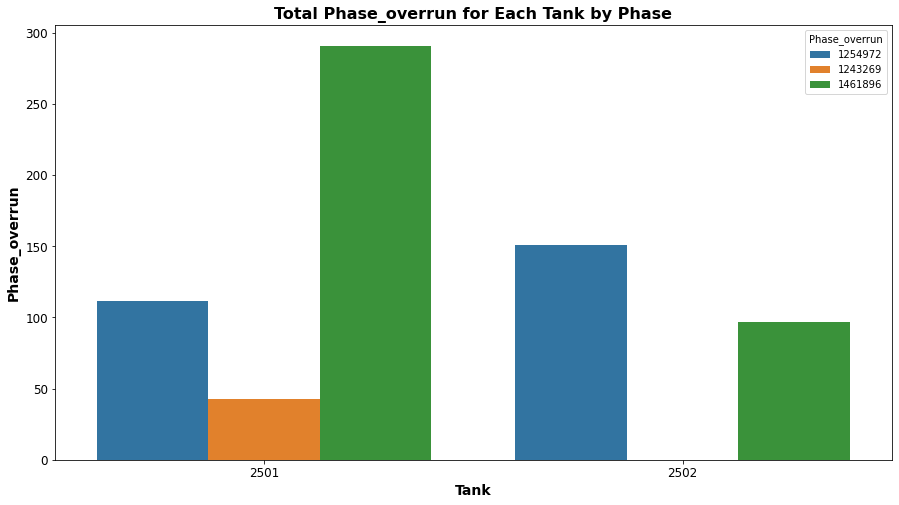

    Tank_1    BATCHID  Phase_duration  Phase_overrun  Phase_start_delay  \
0     2501  107548283             307          276.0                  0   
1     2501  107599589              20            8.0                  0   
2     2501  107619398              55           32.0                  1   
3     2501  107654587              10            8.0                  0   
4     2501  107673784             140          120.0                  0   
5     2501  107692170             140          123.0                  1   
6     2501  107721584               9            7.0                  0   
7     2501  107781849              14           12.0                  0   
8     2501  107799508              60           42.0                  1   
9     2501  107820047              64           50.0                  0   
10    2501  107829242              63           61.0                  0   
11    2501  107837364              14           12.0                  0   
12    2501  107858284    

In [7]:
specific_tanks = [2501, 2502]

data = pd.DataFrame(ProductionTank)

# Filter the dataframe for desired instruction steps
desired_steps = ['1461896', '1254972', '1031006','1243269','1196706','1815609']
filtered_data = data[(data['INGRED_ID'].isin(desired_steps)) & (data['Tank_1'].isin(specific_tanks))]



# Calculate total phase duration for each desired instruction step for each tank and material
total_durations = filtered_data.groupby(['Tank_1', 'Material','INGRED_ID'])['Phase_overrun'].sum().reset_index()

# Present in table format
#print(tabulate(total_durations, headers='keys', tablefmt='grid'))

# Visualization using bar plots
plt.figure(figsize=(15, 8))
sns.barplot(data=total_durations, x='Tank_1', y='Phase_overrun', hue='INGRED_ID', ci=None)
plt.title('Total Phase_overrun for Each Tank by Phase')
plt.ylabel('Phase_overrun')
plt.xlabel('Tank')
plt.legend(title='Phase_overrun')
plt.show()


#Aggregate data per tank
aggregated_total_durations_df4 = filtered_data.groupby(['Tank_1','BATCHID']).agg({
  #  'BATCHID': 'count',
    # 'Material': 'count',
    'Phase_duration': 'sum',
    'Phase_overrun': 'sum',
    'Phase_start_delay':'sum',
    'Quantity':'sum',
    'Flowrate_KGMIN':'sum',
    'Target_Phase_duration':'mean',
    'Target_Flowrate':'mean'
}).reset_index()

 #Print the aggregated DataFrame
print(aggregated_total_durations_df4)
aggregated_total_durations_df4.to_csv('GUMADD25MT4.csv', index=False)

In [8]:
# Define columns where you want to detect and remove outliers
ProductionTank254_df = pd.DataFrame(aggregated_total_durations_df4)
#ProductionTank254_df
columns_to_check = ['Phase_duration', 'Phase_overrun', 'Phase_start_delay', 'Flowrate_KGMIN', 'Target_Phase_duration']

# Define a function to remove outliers using IQR
def remove_outliers_iqr(data, column, iqr_multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for each column
for col in columns_to_check:
   ProductionTank254_df = remove_outliers_iqr(ProductionTank254_df, col)
# Display the cleaned DataFrame
#print(ProductionTank254_df)

In [9]:
# Define columns where you want to detect and remove outliers
ProductionTank254_df1 = pd.DataFrame(aggregated_total_durations_df4)
#ProductionTank254_df
columns_to_check = ['Phase_duration', 'Phase_overrun', 'Phase_start_delay', 'Flowrate_KGMIN', 'Target_Phase_duration']

# Define a function to remove outliers using IQR
def remove_outliers_iqr(data, column, iqr_multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for each column
for col in columns_to_check:
   ProductionTank254_df1 = remove_outliers_iqr(ProductionTank254_df1, col)
# Display the cleaned DataFrame
#print(ProductionTank254_df1)

In [10]:
# Scaling numerical variables (if needed)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['Phase_duration', 'Phase_overrun', 'Phase_start_delay', 'Flowrate_KGMIN']
ProductionTank254_df[numerical_cols] = scaler.fit_transform(ProductionTank254_df[numerical_cols])
print(ProductionTank254_df.head())

   Tank_1    BATCHID  Phase_duration  Phase_overrun  Phase_start_delay  \
1    2501  107599589       -0.680765      -0.761754                0.0   
3    2501  107654587       -0.911421      -0.761754                0.0   
4    2501  107673784        2.087108       2.071335                0.0   
6    2501  107721584       -0.934486      -0.787049                0.0   
7    2501  107781849       -0.819158      -0.660572                0.0   

   Quantity  Flowrate_KGMIN  Target_Phase_duration  Target_Flowrate  
1   172.600        0.498541                   12.0          14.8750  
3    15.077       -1.017904                    2.0           6.3182  
4   758.000       -0.186130                   20.0          38.4615  
6    15.015       -0.983710                    2.0           6.3182  
7    15.035       -1.110267                    2.0           6.3182  


In [11]:
# For the original DataFrame
print("Original DataFrame Summary Statistics:")
print(aggregated_total_durations_df4.describe())

# After removing outliers
print("\nCleaned DataFrame Summary Statistics:")
print(ProductionTank254_df.describe())

Original DataFrame Summary Statistics:
            Tank_1       BATCHID  Phase_duration  Phase_overrun  \
count    50.000000  5.000000e+01       50.000000      50.000000   
mean   2501.480000  1.078399e+08       84.720000      70.740000   
std       0.504672  1.488319e+05       95.268908      91.503498   
min    2501.000000  1.075483e+08        2.000000       0.000000   
25%    2501.000000  1.077141e+08       18.250000       8.000000   
50%    2501.000000  1.078342e+08       56.500000      41.500000   
75%    2502.000000  1.079499e+08      111.750000      97.000000   
max    2502.000000  1.080848e+08      408.000000     393.000000   

       Phase_start_delay    Quantity  Flowrate_KGMIN  Target_Phase_duration  \
count          50.000000   50.000000       50.000000              50.000000   
mean            0.320000  375.725760        7.876278              13.260000   
std             1.300549  251.661395        7.815641               6.355329   
min             0.000000   14.017000     

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from tabulate import tabulate
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (replace 'aggregated_ProductionTank2202_dfGUM' with your actual dataset)
df = pd.DataFrame(ProductionTank254_df)

# Define features and target
# Define features and target
X = df.drop(['Phase_overrun','Target_Flowrate','Target_Phase_duration'], axis=1)
y = df['Phase_overrun']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Train MSE', 'Test MSE', 'Train R2', 'Test R2'])

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)
lr_train_mse = mean_squared_error(y_train, lr_pred_train)
lr_test_mse = mean_squared_error(y_test, lr_pred_test)
lr_train_r2 = r2_score(y_train, lr_pred_train)
lr_test_r2 = r2_score(y_test, lr_pred_test)
results_df = results_df.append({'Model': 'Linear Regression', 'Train MSE': lr_train_mse, 'Test MSE': lr_test_mse, 'Train R2': lr_train_r2, 'Test R2': lr_test_r2}, ignore_index=True)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred_train = ridge_model.predict(X_train)
ridge_pred_test = ridge_model.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_pred_train)
ridge_test_mse = mean_squared_error(y_test, ridge_pred_test)
ridge_train_r2 = r2_score(y_train, ridge_pred_train)
ridge_test_r2 = r2_score(y_test, ridge_pred_test)
results_df = results_df.append({'Model': 'Ridge Regression', 'Train MSE': ridge_train_mse, 'Test MSE': ridge_test_mse, 'Train R2': ridge_train_r2, 'Test R2': ridge_test_r2}, ignore_index=True)

# Lasso Regression
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
lasso_pred_train = lasso_model.predict(X_train)
lasso_pred_test = lasso_model.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_pred_train)
lasso_test_mse = mean_squared_error(y_test, lasso_pred_test)
lasso_train_r2 = r2_score(y_train, lasso_pred_train)
lasso_test_r2 = r2_score(y_test, lasso_pred_test)
results_df = results_df.append({'Model': 'Lasso Regression', 'Train MSE': lasso_train_mse, 'Test MSE': lasso_test_mse, 'Train R2': lasso_train_r2, 'Test R2': lasso_test_r2}, ignore_index=True)

# RandomForest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)
rf_train_mse = mean_squared_error(y_train, rf_pred_train)
rf_test_mse = mean_squared_error(y_test, rf_pred_test)
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_test_r2 = r2_score(y_test, rf_pred_test)
results_df = results_df.append({'Model': 'Random Forest Regressor', 'Train MSE': rf_train_mse, 'Test MSE': rf_test_mse, 'Train R2': rf_train_r2, 'Test R2': rf_test_r2}, ignore_index=True)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)
gb_train_mse = mean_squared_error(y_train, gb_pred_train)
gb_test_mse = mean_squared_error(y_test, gb_pred_test)
gb_train_r2 = r2_score(y_train, gb_pred_train)
gb_test_r2 = r2_score(y_test, gb_pred_test)
results_df = results_df.append({'Model': 'Gradient Boosting Regressor', 'Train MSE': gb_train_mse, 'Test MSE': gb_test_mse, 'Train R2': gb_train_r2, 'Test R2': gb_test_r2}, ignore_index=True)


# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)
dt_train_mse = mean_squared_error(y_train, dt_pred_train)
dt_test_mse = mean_squared_error(y_test, dt_pred_test)
dt_train_r2 = r2_score(y_train, dt_pred_train)
dt_test_r2 = r2_score(y_test, dt_pred_test)
results_df = results_df.append({'Model': 'Decision Tree Regressor', 'Train MSE': dt_train_mse, 'Test MSE': dt_test_mse, 'Train R2': dt_train_r2, 'Test R2': dt_test_r2}, ignore_index=True)

# Bagging Regressor (based on Decision Trees by default)
bag_model = BaggingRegressor(n_estimators=100, random_state=42)
bag_model.fit(X_train, y_train)
bag_pred_train = bag_model.predict(X_train)
bag_pred_test = bag_model.predict(X_test)
bag_train_mse = mean_squared_error(y_train, bag_pred_train)
bag_test_mse = mean_squared_error(y_test, bag_pred_test)
bag_train_r2 = r2_score(y_train, bag_pred_train)
bag_test_r2 = r2_score(y_test, bag_pred_test)
results_df = results_df.append({'Model': 'Bagging Regressor', 'Train MSE': bag_train_mse, 'Test MSE': bag_test_mse, 'Train R2': bag_train_r2, 'Test R2': bag_test_r2}, ignore_index=True)

# AdaBoost Regressor
ada_model = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred_train = ada_model.predict(X_train)
ada_pred_test = ada_model.predict(X_test)
ada_train_mse = mean_squared_error(y_train, ada_pred_train)
ada_test_mse = mean_squared_error(y_test, ada_pred_test)
ada_train_r2 = r2_score(y_train, ada_pred_train)
ada_test_r2 = r2_score(y_test, ada_pred_test)
results_df = results_df.append({'Model': 'AdaBoost Regressor', 'Train MSE': ada_train_mse, 'Test MSE': ada_test_mse, 'Train R2': ada_train_r2, 'Test R2': ada_test_r2}, ignore_index=True)

# Extra Trees Regressor
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)
et_pred_train = et_model.predict(X_train)
et_pred_test = et_model.predict(X_test)
et_train_mse = mean_squared_error(y_train, et_pred_train)
et_test_mse = mean_squared_error(y_test, et_pred_test)
et_train_r2 = r2_score(y_train, et_pred_train)
et_test_r2 = r2_score(y_test, et_pred_test)
results_df = results_df.append({'Model': 'Extra Trees Regressor', 'Train MSE': et_train_mse, 'Test MSE': et_test_mse, 'Train R2': et_train_r2, 'Test R2': et_test_r2}, ignore_index=True)


# Print the results DataFrame
#print(results_df)
# Print the results DataFrame in tabulated form
print(tabulate(results_df, headers='keys', tablefmt='grid'))
# Save results DataFrame to an Excel file
results_df.to_excel('254AGresults.xlsx', index=False)

+----+-----------------------------+-------------+------------+------------+-----------+
|    | Model                       |   Train MSE |   Test MSE |   Train R2 |   Test R2 |
+====+=============================+=============+============+============+===========+
|  0 | Linear Regression           | 0.00393252  | 0.00430841 |   0.996431 |  0.992714 |
+----+-----------------------------+-------------+------------+------------+-----------+
|  1 | Ridge Regression            | 0.00931396  | 0.00752868 |   0.991547 |  0.987269 |
+----+-----------------------------+-------------+------------+------------+-----------+
|  2 | Lasso Regression            | 0.441399    | 0.711067   |   0.599415 | -0.202425 |
+----+-----------------------------+-------------+------------+------------+-----------+
|  3 | Random Forest Regressor     | 0.00605004  | 0.0136699  |   0.994509 |  0.976884 |
+----+-----------------------------+-------------+------------+------------+-----------+
|  4 | Gradient Boost

In [13]:
# Create a list of models with their respective hyperparameters
# Initialize models
models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=1.0),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    MLPRegressor(),
    DecisionTreeRegressor(random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42)
]

# Perform cross-validation for each model
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert negative MSE back to positive
    mean_mse = mse_scores.mean()
    std_mse = mse_scores.std()
    print(f"{model_name}:\n  Mean MSE: {mean_mse:.6f}\n  Std MSE: {std_mse:.6f}\n")
    
     # Save the results to an Excel file
df.to_excel("25MT04AGresultsCVmodel_results.xlsx", index=False)
#a file named model_results.xlsx in the current working directory containing the mean and standard deviation of the MSE for each model


LinearRegression:
  Mean MSE: 0.006891
  Std MSE: 0.002430

Ridge:
  Mean MSE: 0.011605
  Std MSE: 0.004483

Lasso:
  Mean MSE: 0.582356
  Std MSE: 0.304844

RandomForestRegressor:
  Mean MSE: 0.083164
  Std MSE: 0.049218

GradientBoostingRegressor:
  Mean MSE: 0.059240
  Std MSE: 0.017882

SVR:
  Mean MSE: 1.383885
  Std MSE: 0.983757

MLPRegressor:
  Mean MSE: 936775542701.711304
  Std MSE: 1692771431154.216797

DecisionTreeRegressor:
  Mean MSE: 0.116198
  Std MSE: 0.037478

AdaBoostRegressor:
  Mean MSE: 0.120280
  Std MSE: 0.080920

BaggingRegressor:
  Mean MSE: 0.066803
  Std MSE: 0.032379



In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Load your dataset (replace  with your actual dataset)
df = pd.DataFrame(ProductionTank254_df)

# Define features and target
# Define features and target
X = df.drop(['Phase_overrun','Target_Flowrate','Target_Phase_duration'], axis=1)
y = df['Phase_overrun']




# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Train MSE', 'Test MSE', 'Train R2', 'Test R2'])

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)
lr_train_mse = mean_squared_error(y_train, lr_pred_train)
lr_test_mse = mean_squared_error(y_test, lr_pred_test)
lr_train_r2 = r2_score(y_train, lr_pred_train)
lr_test_r2 = r2_score(y_test, lr_pred_test)
results_df = results_df.append({'Model': 'Linear Regression', 'Train MSE': lr_train_mse, 'Test MSE': lr_test_mse, 'Train R2': lr_train_r2, 'Test R2': lr_test_r2}, ignore_index=True)

# Ridge Regression with Hyperparameter Tuning
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
ridge_pred_train = best_ridge.predict(X_train)
ridge_pred_test = best_ridge.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_pred_train)
ridge_test_mse = mean_squared_error(y_test, ridge_pred_test)
ridge_train_r2 = r2_score(y_train, ridge_pred_train)
ridge_test_r2 = r2_score(y_test, ridge_pred_test)
results_df = results_df.append({'Model': 'Ridge Regression', 'Train MSE': ridge_train_mse, 'Test MSE': ridge_test_mse, 'Train R2': ridge_train_r2, 'Test R2': ridge_test_r2}, ignore_index=True)
print(f"Best parameters for Ridge Regression: {ridge_grid.best_params_}")
# Lasso Regression with Hyperparameter Tuning
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
lasso_pred_train = best_lasso.predict(X_train)
lasso_pred_test = best_lasso.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_pred_train)
lasso_test_mse = mean_squared_error(y_test, lasso_pred_test)
lasso_train_r2 = r2_score(y_train, lasso_pred_train)
lasso_test_r2 = r2_score(y_test, lasso_pred_test)
results_df = results_df.append({'Model': 'Lasso Regression', 'Train MSE': lasso_train_mse, 'Test MSE': lasso_test_mse, 'Train R2': lasso_train_r2, 'Test R2': lasso_test_r2}, ignore_index=True)
print(f"Best parameters for Lasso Regression: {lasso_grid.best_params_}")
# Random Forest Regressor with Hyperparameter Tuning
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rf_pred_train = best_rf.predict(X_train)
rf_pred_test = best_rf.predict(X_test)
rf_train_mse = mean_squared_error(y_train, rf_pred_train)
rf_test_mse = mean_squared_error(y_test, rf_pred_test)
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_test_r2 = r2_score(y_test, rf_pred_test)
rf_feature_importance = rf_model.feature_importances_
results_df = results_df.append({'Model': 'Random Forest Regressor', 'Train MSE': rf_train_mse, 'Test MSE': rf_test_mse, 'Train R2': rf_train_r2, 'Test R2': rf_test_r2}, ignore_index=True)
print(f"Best parameters for Random Forest Regressor: {rf_grid.best_params_}")
# Gradient Boosting Regressor with Hyperparameter Tuning
gb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_params, cv=5)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
gb_pred_train = best_gb.predict(X_train)
gb_pred_test = best_gb.predict(X_test)
gb_train_mse = mean_squared_error(y_train, gb_pred_train)
gb_test_mse = mean_squared_error(y_test, gb_pred_test)
gb_train_r2 = r2_score(y_train, gb_pred_train)
gb_test_r2 = r2_score(y_test, gb_pred_test)
gb_feature_importance = rf_model.feature_importances_
results_df = results_df.append({'Model': 'Gradient Boosting Regressor', 'Train MSE': gb_train_mse, 'Test MSE': gb_test_mse, 'Train R2': gb_train_r2, 'Test R2': gb_test_r2}, ignore_index=True)
print(f"Best parameters for Gradient Boosting Regressor: {gb_grid.best_params_}")
# Decision Tree Regressor with Hyperparameter Tuning
dt_params = {'max_depth': [None, 10, 20]}
dt_grid = GridSearchCV(DecisionTreeRegressor(), dt_params, cv=5)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
dt_pred_train = best_dt.predict(X_train)
dt_pred_test = best_dt.predict(X_test)
dt_train_mse = mean_squared_error(y_train, dt_pred_train)
dt_test_mse = mean_squared_error(y_test, dt_pred_test)
dt_train_r2 = r2_score(y_train, dt_pred_train)
dt_test_r2 = r2_score(y_test, dt_pred_test)
results_df = results_df.append({'Model': 'Decision Tree Regressor', 'Train MSE': dt_train_mse, 'Test MSE': dt_test_mse, 'Train R2': dt_train_r2, 'Test R2': dt_test_r2}, ignore_index=True)
print(f"Best parameters for Decision Tree Regressor: {dt_grid.best_params_}")


# Bagging Regressor with Hyperparameter Tuning
bag_params = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

bag_grid = GridSearchCV(BaggingRegressor(random_state=42), bag_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
bag_grid.fit(X_train, y_train)
bag_best = bag_grid.best_estimator_

# Using the best estimator from GridSearch to make predictions
bag_pred_train = bag_best.predict(X_train)
bag_pred_test = bag_best.predict(X_test)
bag_train_mse = mean_squared_error(y_train, bag_pred_train)
bag_test_mse = mean_squared_error(y_test, bag_pred_test)
bag_train_r2 = r2_score(y_train, bag_pred_train)
bag_test_r2 = r2_score(y_test, bag_pred_test)
results_df = results_df.append({'Model': 'Bagging Regressor', 'Train MSE': bag_train_mse, 'Test MSE': bag_test_mse, 'Train R2': bag_train_r2, 'Test R2': bag_test_r2}, ignore_index=True)
print(f"Best parameters for Bagging Regressor: {bag_grid.best_params_}")


# AdaBoost Regressor with Hyperparameter Tuning
ada_model = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}
ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), ada_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ada_model.fit(X_train, y_train)
ada_pred_train = ada_model.predict(X_train)
ada_pred_test = ada_model.predict(X_test)
ada_train_mse = mean_squared_error(y_train, ada_pred_train)
ada_test_mse = mean_squared_error(y_test, ada_pred_test)
ada_train_r2 = r2_score(y_train, ada_pred_train)
ada_test_r2 = r2_score(y_test, ada_pred_test)
results_df = results_df.append({'Model': 'AdaBoost Regressor', 'Train MSE': ada_train_mse, 'Test MSE': ada_test_mse, 'Train R2': ada_train_r2, 'Test R2': ada_test_r2}, ignore_index=True)




# Print the results DataFrame
print(results_df)
# Print the results DataFrame in tabulated form
print(tabulate(results_df, headers='keys', tablefmt='grid'))
# Save results DataFrame to an Excel file
results_df.to_excel('254AGresultsTUNED.xlsx', index=False)

Best parameters for Ridge Regression: {'alpha': 0.1}
Best parameters for Lasso Regression: {'alpha': 0.01}
Best parameters for Random Forest Regressor: {'max_depth': 20, 'n_estimators': 200}
Best parameters for Gradient Boosting Regressor: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best parameters for Decision Tree Regressor: {'max_depth': 20}
Best parameters for Bagging Regressor: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
                         Model     Train MSE  Test MSE  Train R2   Test R2
0            Linear Regression  3.932518e-03  0.004308  0.996431  0.992714
1             Ridge Regression  4.029972e-03  0.004155  0.996343  0.992973
2             Lasso Regression  4.247754e-03  0.004039  0.996145  0.993171
3      Random Forest Regressor  9.365657e-03  0.015476  0.991500  0.973830
4  Gradient Boosting Regressor  1.972777e-10  0.009870  1.000000  0.983309
5      Decision Tree Regressor  0.000000e+00  0.021298  1.000000  0.963984
6          

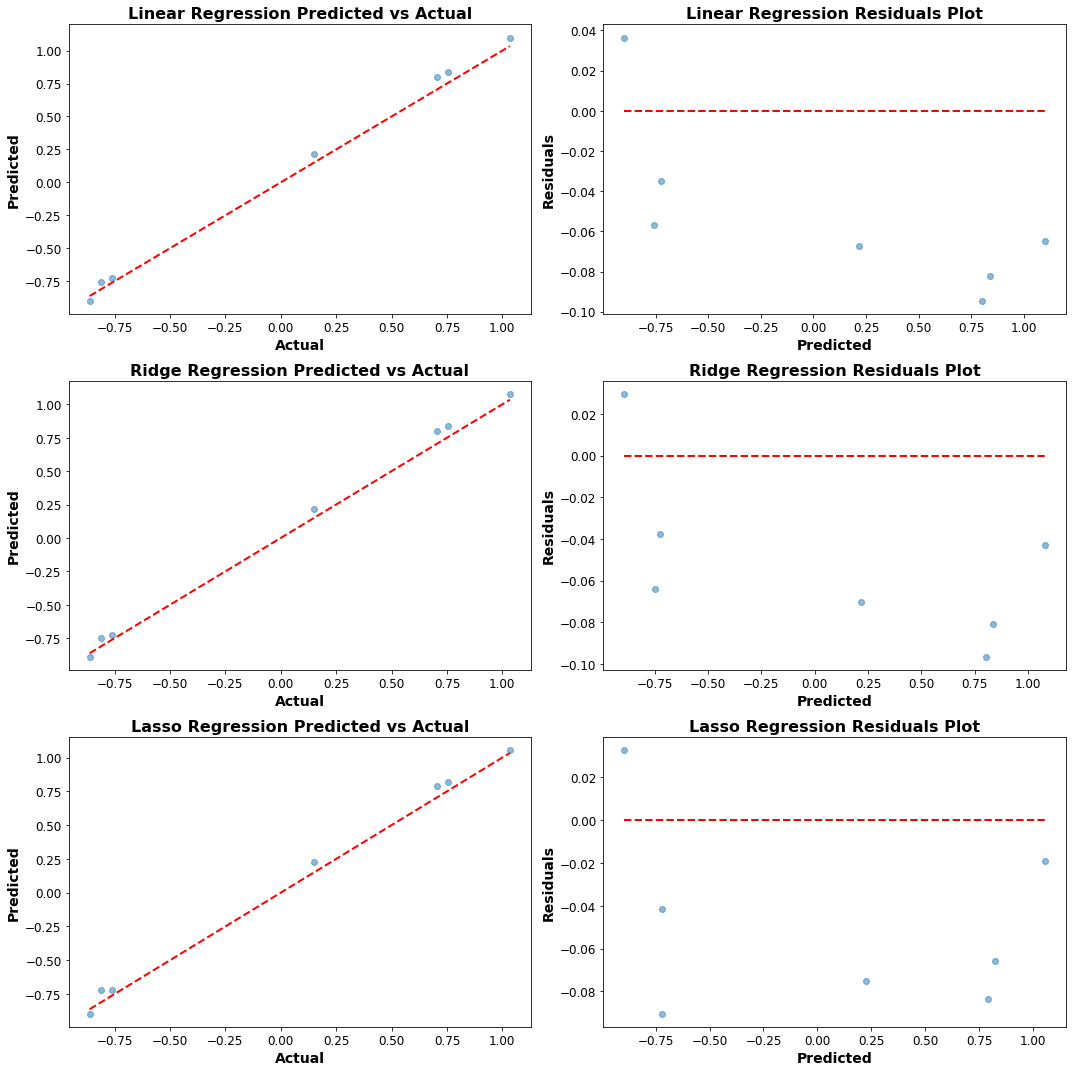

In [15]:
# Visualization function
def plot_predictions(models, actual, predictions, model_names):
    fig, ax = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
    
    for i, (model, pred, name) in enumerate(zip(models, predictions, model_names)):
        # Scatter plot of predicted vs actual
        ax[i][0].scatter(actual, pred, alpha=0.5)
        ax[i][0].plot([min(actual), max(actual)], [min(actual), max(actual)], '--', lw=2, color='red')
        ax[i][0].set_title(f'{name} Predicted vs Actual')
        ax[i][0].set_xlabel('Actual')
        ax[i][0].set_ylabel('Predicted')

        # Residuals plot
        residuals = actual - pred
        ax[i][1].scatter(pred, residuals, alpha=0.5)
        ax[i][1].hlines(0, min(pred), max(pred), colors='red', linestyles='--', lw=2)
        ax[i][1].set_title(f'{name} Residuals Plot')
        ax[i][1].set_xlabel('Predicted')
        ax[i][1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

# Collecting models and their predictions
models_list = [lr_model, best_ridge, best_lasso]
predictions_list = [lr_pred_test, ridge_pred_test, lasso_pred_test]
model_names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

# Plotting
plot_predictions(models_list, y_test, predictions_list, model_names)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

# Assuming you've loaded 'ProductionTank22_df2' somewhere in your code
df = pd.DataFrame(ProductionTank254_df1)

# Define features and target
X = df.drop(['Phase_overrun','Target_Flowrate','Target_Phase_duration'], axis=1)
y = df['Phase_overrun']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_df = pd.DataFrame(columns=['Model', 'Train MSE', 'Test MSE', 'Train R2', 'Test R2', 'CV MSE Mean', 'CV MSE Std'])

# Function to perform model training, prediction and storing results
def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    train_mse = mean_squared_error(y_train, pred_train)
    test_mse = mean_squared_error(y_test, pred_test)
    
    train_r2 = r2_score(y_train, pred_train)
    test_r2 = r2_score(y_test, pred_test)
    
    # Perform cross-validation
    cv_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results_df.loc[name] = [name, train_mse, test_mse, train_r2, test_r2, cv_mean, cv_std]

# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
evaluate_model(knn_model, 'K-Nearest Neighbors')

# Support Vector Machine
svm_model = SVR(kernel='rbf')
evaluate_model(svm_model, 'Support Vector Machine')

print(tabulate(results_df, headers='keys', tablefmt='grid'))

results_df.to_excel('knn_svm_results.xlsx', index=False)

def hypertune_model(model, params, name):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_

    evaluate_model(best_model, name)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
hypertune_model(KNeighborsRegressor(), knn_params, 'K-Nearest Neighbors')

# Support Vector Machine
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3],
    'gamma': ['scale', 'auto']
}
hypertune_model(SVR(), svm_params, 'Support Vector Machine')

print(tabulate(results_df, headers='keys', tablefmt='grid'))

results_df.to_excel('knn_svm_25MT4resultsTUNED_hyper_tuned.xlsx', index=False)

+------------------------+------------------------+-------------+------------+------------+-----------+---------------+--------------+
|                        | Model                  |   Train MSE |   Test MSE |   Train R2 |   Test R2 |   CV MSE Mean |   CV MSE Std |
+========================+========================+=============+============+============+===========+===============+==============+
| K-Nearest Neighbors    | K-Nearest Neighbors    |     228.046 |    89.7943 |   0.867575 |  0.902841 |       400.067 |      389.499 |
+------------------------+------------------------+-------------+------------+------------+-----------+---------------+--------------+
| Support Vector Machine | Support Vector Machine |    1961.15  |  1266.53   |  -0.138828 | -0.370397 |      2142.93  |     1468.68  |
+------------------------+------------------------+-------------+------------+------------+-----------+---------------+--------------+
Fitting 5 folds for each of 32 candidates, totalling 16

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tabulate import tabulate

# Load your dataset (replace 'ProductionTank22_df2' with your actual dataset)
df = pd.DataFrame(ProductionTank254_df1)

# Define features and target
#X = df.drop(['Phase_overrun', 'Target_Flowrate', 'Target_Phase_duration'], axis=1)
#y = df['Phase_overrun']

# Define features and target
X = df.drop(['Phase_overrun','Target_Flowrate','Target_Phase_duration'], axis=1)
y = df['Phase_overrun']


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Train MSE', 'Test MSE', 'Train R2', 'Test R2'])

# Define a simple feedforward neural network
def build_simple_nn():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate the simple neural network
simple_nn = build_simple_nn()
simple_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
pred_train_simple_nn = simple_nn.predict(X_train_scaled)
pred_test_simple_nn = simple_nn.predict(X_test_scaled)
train_mse_simple_nn = mean_squared_error(y_train, pred_train_simple_nn)
test_mse_simple_nn = mean_squared_error(y_test, pred_test_simple_nn)
train_r2_simple_nn = r2_score(y_train, pred_train_simple_nn)
test_r2_simple_nn = r2_score(y_test, pred_test_simple_nn)
results_df = results_df.append({'Model': 'Simple Neural Network', 'Train MSE': train_mse_simple_nn,
                                'Test MSE': test_mse_simple_nn, 'Train R2': train_r2_simple_nn, 'Test R2': test_r2_simple_nn},
                               ignore_index=True)

print(tabulate(results_df, headers='keys', tablefmt='grid'))

results_df.to_excel('Simple Neural Network.xlsx', index=False)

from keras.layers import LSTM

# Assuming X_train_scaled and X_test_scaled are already prepared

# Reshape input data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Define LSTM model
def build_lstm():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate the LSTM
lstm = build_lstm()
lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
pred_train_lstm = lstm.predict(X_train_reshaped)
pred_test_lstm = lstm.predict(X_test_reshaped)
train_mse_lstm = mean_squared_error(y_train, pred_train_lstm)
test_mse_lstm = mean_squared_error(y_test, pred_test_lstm)
train_r2_lstm = r2_score(y_train, pred_train_lstm)
test_r2_lstm = r2_score(y_test, pred_test_lstm)
results_df = results_df.append({'Model': 'LSTM Neural Network', 'Train MSE': train_mse_lstm,
                                'Test MSE': test_mse_lstm, 'Train R2': train_r2_lstm, 'Test R2': test_r2_lstm},
                               ignore_index=True)
print(tabulate(results_df, headers='keys', tablefmt='grid'))


results_df.to_excel('25MT4AGresultsTUNEDLSTMSNN Neural Network.xlsx', index=False)


1/1 [==============================] - 0s 58ms/step
+----+-----------------------+-------------+------------+------------+-----------+
|    | Model                 |   Train MSE |   Test MSE |   Train R2 |   Test R2 |
+====+=======================+=============+============+============+===========+
|  0 | Simple Neural Network |     2718.59 |    2150.59 |   -0.57867 |  -1.32696 |
+----+-----------------------+-------------+------------+------------+-----------+
1/1 [==============================] - 0s 49ms/step
+----+-----------------------+-------------+------------+------------+-----------+
|    | Model                 |   Train MSE |   Test MSE |   Train R2 |   Test R2 |
+====+=======================+=============+============+============+===========+
|  0 | Simple Neural Network |     2718.59 |    2150.59 |  -0.57867  |  -1.32696 |
+----+-----------------------+-------------+------------+------------+-----------+
|  1 | LSTM Neural Network   |     3124.46 |    2448.64 |  -0.8143

In [18]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# ... [your data loading, preprocessing, etc.]

# Define a parameter grid to search through
param_grid = {
    'dense1_neurons': [32, 64, 128],
    'dense2_neurons': [16, 32, 64],
    'epochs': [30, 50],
    'batch_size': [16, 32, 64],
}

# Adjust the function to take the hyperparameters as parameters
def build_simple_nn(dense1_neurons=64, dense2_neurons=32):
    model = Sequential()
    model.add(Dense(dense1_neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(dense2_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
simple_nn_model = KerasRegressor(build_fn=build_simple_nn, verbose=0)

# GridSearchCV
simple_nn_search = GridSearchCV(estimator=simple_nn_model, param_grid=param_grid, cv=3, verbose=1)
simple_nn_search_result = simple_nn_search.fit(X_train_scaled, y_train)

# Display the best parameters
print("Best Simple NN Params:", simple_nn_search_result.best_params_)

# Predict using the best model on training data
train_preds = simple_nn_search.best_estimator_.predict(X_train_scaled)

# Calculate the MSE and R2 for the training data
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Predict using the best model on test data
test_preds = simple_nn_search.best_estimator_.predict(X_test_scaled)

# Calculate the MSE and R2 for the test data
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

# Print the results
print("Training MSE:", train_mse)
print("Training R^2:", train_r2)
print("Test MSE:", test_mse)
print("Test R^2:", test_r2)

# Here, you can use simple_nn_search_result.best_estimator_ to make predictions and evaluate the model.

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Simple NN Params: {'batch_size': 16, 'dense1_neurons': 128, 'dense2_neurons': 64, 'epochs': 50}
Training MSE: 1081.8715863738864
Training R^2: 0.37176288715107253
Test MSE: 835.2321330268663
Test R^2: 0.09626872502944728


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model for grid search
def create_lstm(lstm_neurons=50):
    model = Sequential()
    model.add(LSTM(lstm_neurons, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Grid search hyperparameters
lstm_param_grid = {
    'lstm_neurons': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'epochs': [30, 50, 100]
}

lstm_model = KerasRegressor(build_fn=create_lstm, verbose=0)
lstm_search = GridSearchCV(estimator=lstm_model, param_grid=lstm_param_grid, cv=3, verbose=1)
lstm_search_result = lstm_search.fit(X_train_reshaped, y_train)

# Print the best parameters
print("Best LSTM Params:", lstm_search_result.best_params_)

# Predict using the best model on training data
train_preds_lstm = lstm_search_result.best_estimator_.predict(X_train_reshaped)

# Calculate the MSE and R2 for the training data
train_mse_lstm = mean_squared_error(y_train, train_preds_lstm)
train_r2_lstm = r2_score(y_train, train_preds_lstm)

# Predict using the best model on test data
test_preds_lstm = lstm_search_result.best_estimator_.predict(X_test_reshaped)

# Calculate the MSE and R2 for the test data
test_mse_lstm = mean_squared_error(y_test, test_preds_lstm)
test_r2_lstm = r2_score(y_test, test_preds_lstm)

# Print the results
print("Training MSE for LSTM:", train_mse_lstm)
print("Training R^2 for LSTM:", train_r2_lstm)
print("Test MSE for LSTM:", test_mse_lstm)
print("Test R^2 for LSTM:", test_r2_lstm)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [ ]:
#!pip install -U keras-tuner
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters grid for Simple Neural Network
def create_simple_nn(neurons_layer1=64, neurons_layer2=32):
    model = Sequential()
    model.add(Dense(neurons_layer1, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

simple_nn_param_grid = {
    'neurons_layer1': [32, 64, 128],
    'neurons_layer2': [16, 32, 64],
    'batch_size': [16, 32, 64],
    'epochs': [30, 50, 100]
}

simple_nn_model = KerasRegressor(build_fn=create_simple_nn, verbose=0)
simple_nn_search = RandomizedSearchCV(estimator=simple_nn_model, param_distributions=simple_nn_param_grid, n_iter=5, cv=3, verbose=1)
simple_nn_search_result = simple_nn_search.fit(X_train_scaled, y_train)

# Display results for Simple NN
simple_nn_results = pd.DataFrame(simple_nn_search_result.cv_results_)[['param_neurons_layer1', 'param_neurons_layer2', 'param_batch_size', 'param_epochs', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print(tabulate(simple_nn_results, headers='keys', tablefmt='grid'))
# Save results DataFrame to an Excel file
simple_nn_results.to_excel('simple_nn.xlsx', index=False)
print("Best Simple NN Params:", simple_nn_search_result.best_params_)

# Define hyperparameters grid for LSTM
def create_lstm(lstm_neurons=50):
    model = Sequential()
    model.add(LSTM(lstm_neurons, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_param_grid = {
    'lstm_neurons': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'epochs': [30, 50, 100]
}

lstm_model = KerasRegressor(build_fn=create_lstm, verbose=0)
lstm_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=lstm_param_grid, n_iter=5, cv=3, verbose=1)
lstm_search_result = lstm_search.fit(X_train_reshaped, y_train)

# Display results for LSTM
lstm_results = pd.DataFrame(lstm_search_result.cv_results_)[['param_lstm_neurons', 'param_batch_size', 'param_epochs', 'mean_test_score', 'std_test_score', 'rank_test_score']]
print(tabulate(lstm_results, headers='keys', tablefmt='grid'))
print("Best LSTM Params:", lstm_search_result.best_params_)
# Save results DataFrame to an Excel file
lstm_results.to_excel('25MT4GAGresultsLSTMTUNED.xlsx', index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from tabulate import tabulate

# Load your dataset (replace 'ProductionTank25MT04_df2' with your actual dataset)
df = pd.DataFrame(ProductionTank254_df1)


# Define features and target
X = df.drop(['Phase_overrun','Target_Flowrate','Target_Phase_duration'], axis=1)
y = df['Phase_overrun']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Train MSE', 'Test MSE', 'Train R2', 'Test R2'])

# Define a simple feedforward neural network
def build_simple_nn():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate the simple neural network
simple_nn = build_simple_nn()
simple_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
pred_train_simple_nn = simple_nn.predict(X_train_scaled)
pred_test_simple_nn = simple_nn.predict(X_test_scaled)
train_mse_simple_nn = mean_squared_error(y_train, pred_train_simple_nn)
test_mse_simple_nn = mean_squared_error(y_test, pred_test_simple_nn)
train_r2_simple_nn = r2_score(y_train, pred_train_simple_nn)
test_r2_simple_nn = r2_score(y_test, pred_test_simple_nn)
results_df = results_df.append({'Model': 'Dense Neural Network', 'Train MSE': train_mse_simple_nn,
                                'Test MSE': test_mse_simple_nn, 'Train R2': train_r2_simple_nn, 'Test R2': test_r2_simple_nn},
                               ignore_index=True)

# Print the results DataFrame
print(tabulate(results_df, headers='keys', tablefmt='grid'))

# Save results DataFrame to an Excel file
results_df.to_excel('254neural_network_results1.xlsx', index=False)

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def create_model(neurons_layer1=128, neurons_layer2=64, neurons_layer3=32):
    model = Sequential()
    model.add(Dense(neurons_layer1, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dense(neurons_layer3, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

param_dist = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 50, 100],
    'neurons_layer1': [64, 128, 256],
    'neurons_layer2': [32, 64, 128],
    'neurons_layer3': [16, 32, 64]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_search_result = random_search.fit(X_train_scaled, y_train)

print("Best Score: ", random_search_result.best_score_)
print("Best Params: ", random_search_result.best_params_)

best_nn = random_search_result.best_estimator_.model
pred_train_best_nn = best_nn.predict(X_train_scaled)
pred_test_best_nn = best_nn.predict(X_test_scaled)

train_mse_best_nn = mean_squared_error(y_train, pred_train_best_nn)
test_mse_best_nn = mean_squared_error(y_test, pred_test_best_nn)
train_r2_best_nn = r2_score(y_train, pred_train_best_nn)
test_r2_best_nn = r2_score(y_test, pred_test_best_nn)

results_df = results_df.append({'Model': 'Dense Neural Network (Optimized)', 'Train MSE': train_mse_best_nn,
                                'Test MSE': test_mse_best_nn, 'Train R2': train_r2_best_nn, 'Test R2': test_r2_best_nn},
                               ignore_index=True)
#Remember that the parameters given above are just examples; you can expand or restrict the grid as per your computational capability and needs. Also, depending on the number of combinations and the size of your data, this can take a significant amount of time to run.


best_nn = random_search_result.best_estimator_.model
pred_train_best_nn = best_nn.predict(X_train_scaled)
pred_test_best_nn = best_nn.predict(X_test_scaled)

train_mse_best_nn = mean_squared_error(y_train, pred_train_best_nn)
test_mse_best_nn = mean_squared_error(y_test, pred_test_best_nn)
train_r2_best_nn = r2_score(y_train, pred_train_best_nn)
test_r2_best_nn = r2_score(y_test, pred_test_best_nn)

results_df = results_df.append({'Model': 'Dense Neural Network (Optimized)', 'Train MSE': train_mse_best_nn,
                                'Test MSE': test_mse_best_nn, 'Train R2': train_r2_best_nn, 'Test R2': test_r2_best_nn},
                               ignore_index=True)

print(tabulate(results_df, headers='keys', tablefmt='grid'))


results_df.to_excel('25MT4GAGTdenseNN_results.xlsx', index=False)